## Assignment

In this assignment, you'll be working with the [U.S. Education Dataset](https://www.kaggle.com/noriuk/us-education-datasets-unification-project/home) from Kaggle. The data gives detailed state level information on several facets of the state of education on an annual basis. To learn more about the data and the column descriptions, click the Kaggle link above. 

Access this data from the Thinkful database using the following credentials:

postgres_user = 'dsbc_student'<br>
postgres_pw = '7\*.8G9QH21'<br>
postgres_host = '142.93.121.174'<br>
postgres_port = '5432'<br>
postgres_db = 'useducation'<br>

To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

1. Determine all the variable types and find the fraction of the missing values for each variable.
2. Notice that the data has a time dimension (year). For this assignment, forget about time and treat all the observations as if they're from the same year. Choose a strategy to deal with the missing values for each variables. For which variables would filling in the missing values with some value make sense? For which might tossing out the records entirely make sense?
3. Now, take into account the time factor. Replicate your second answer but this time fill in the missing values by using a statistic that is calculated within the year of the observation. For example, if you want to fill a missing value for a variable with the mean of that variable, calculate the mean by using *only* the observations for that specific year.
4. This time, fill in the missing values using interpolation (extrapolation).
5. Compare your results for the 2nd, 3rd, and 4th questions. Do you find any meaningful differences?

In [234]:
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [235]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

education = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

#### 1. Determine all the variable types and find the fraction of the missing values for each variable.

In [236]:
education.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN


In [237]:
#Getting the fraction of the missing values for each variable

round(education.isnull().sum()*100/education.isnull().count(),2)


PRIMARY_KEY                      0.00
STATE                            0.00
YEAR                             0.00
ENROLL                          17.63
TOTAL_REVENUE                   14.21
FEDERAL_REVENUE                 14.21
STATE_REVENUE                   14.21
LOCAL_REVENUE                   14.21
TOTAL_EXPENDITURE               14.21
INSTRUCTION_EXPENDITURE         14.21
SUPPORT_SERVICES_EXPENDITURE    14.21
OTHER_EXPENDITURE               17.63
CAPITAL_OUTLAY_EXPENDITURE      14.21
GRADES_PK_G                     11.60
GRADES_KG_G                      8.85
GRADES_4_G                       8.78
GRADES_8_G                       8.78
GRADES_12_G                      8.78
GRADES_1_8_G                     8.78
GRADES_9_12_G                    8.78
GRADES_ALL_G                    11.60
AVG_MATH_4_SCORE                64.08
AVG_MATH_8_SCORE                64.34
AVG_READING_4_SCORE             64.28
AVG_READING_8_SCORE             66.62
dtype: float64

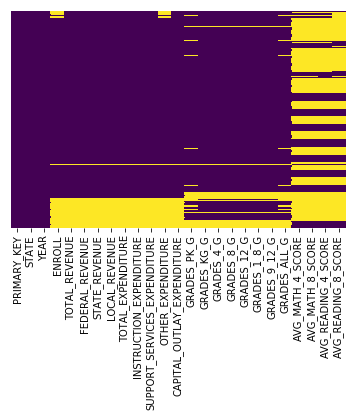

In [238]:
sns.heatmap(education.isnull(),yticklabels=False,cbar=False,cmap='viridis')

**2. Notice that the data has a time dimension (year). For this assignment, forget about time and treat all the observations as if they're from the same year. Choose a strategy to deal with the missing values for each variables. For which variables would filling in the missing values with some value make sense? For which might tossing out the records entirely make sense?**

**ENROLL**

Base on dataset description, this variable should be comparable to GRADES_ALL. Reviewing the visualization above, GRADES_ALL is more complete than ENROLL, so I skip to clean this columns and I'll focus on cleaning GRADES_ALL coluimn.

**TOTAL_REVENUE**

Base on dataset description, this variable is the result of the sum of the next three columns: FEDERAL_REVENUE, STATE_REVENUE and LOCAL_REVENUE. If it's true we can skip to clean this column and cleaning the other 3 columns.

Let's make sure that saying above is true.

In [239]:
#Create a new column with sum of FEDERAL_REVENUE, STATE_REVENUE and LOCAL_REVENUE variables.
education['total_revenue'] = education['FEDERAL_REVENUE'] + education['STATE_REVENUE'] + education['LOCAL_REVENUE']

#Make a sustraction between columns, the result for all rows should be 0
education['diff_totalrevenue'] = education['total_revenue'] - pd.to_numeric(education['TOTAL_REVENUE'], downcast='integer')

#Verifying results
print('Number of unique values: {} '.format(education['diff_totalrevenue'].nunique()))

#As we got 2 different values and it's expected just 1 value, let's see what values are
print('Unique values:\n {} '.format(education['diff_totalrevenue'].value_counts()))


Number of unique values: 2 
Unique values:
  0.0    1279
-8.0       1
Name: diff_totalrevenue, dtype: int64 


In [240]:
education[education['diff_totalrevenue']<0][['TOTAL_REVENUE','total_revenue','diff_totalrevenue','FEDERAL_REVENUE','STATE_REVENUE','LOCAL_REVENUE']]

,TOTAL_REVENUE,total_revenue,diff_totalrevenue,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE
430,8489991.0,8489983.0,-8.0,426266.0,4300608.0,3763109.0


_The difference is not significant, we can skip cleaning TOTAL-REVENUE column_

**FEDERAL_REVENUE, STATE_REVENUE and LOCAL_REVENUE columns**

In [241]:
#Let's search a clue of null values for these columns: FEDERAL_REVENUE,STATE_REVENUE and LOCAL_REVENUE

education.groupby('YEAR')[['TOTAL_REVENUE','FEDERAL_REVENUE','STATE_REVENUE','LOCAL_REVENUE']].median().sort_values(by='YEAR',ascending=False).iloc[0:10]

,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE
YEAR,,,,
2017,NaN,NaN,NaN,NaN
2016,7745928.0,690724.0,4097696.0,2974057.0
2015,7548871.0,688990.0,4075118.0,2856603.0
2014,7357267.0,681230.0,3902923.0,2753227.0
2013,7216175.0,707522.0,3693829.0,2703800.0
2012,7192430.0,773014.0,3588546.0,3069526.0
2011,7376725.0,969288.0,3269321.0,2964028.0
2010,7081504.5,882273.0,3293222.0,2628838.5
2009,6946656.0,665937.0,3587748.5,2570483.5


In [242]:
#Is there any data from 2017

education[education['YEAR']==2017].iloc[0:10]

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,total_revenue,diff_totalrevenue
372,2017_RHODE_ISLAND,RHODE_ISLAND,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,237.554934,277.180126,223.353443,269.553823,NaN,NaN
593,2017_SOUTH_CAROLINA,SOUTH_CAROLINA,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,234.043993,274.673821,213.127835,265.767860,NaN,NaN
916,2017_SOUTH_DAKOTA,SOUTH_DAKOTA,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,241.588947,286.376160,221.750123,259.753002,NaN,NaN
1059,2017_OKLAHOMA,OKLAHOMA,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,237.326270,274.688883,216.587775,268.450642,NaN,NaN
1097,2017_OREGON,OREGON,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,233.132460,282.173028,217.531073,261.236934,NaN,NaN
1349,2017_PENNSYLVANIA,PENNSYLVANIA,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,241.672327,286.393832,224.924702,266.216684,NaN,NaN
1447,2017_ALABAMA,ALABAMA,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,232.170688,268.312020,216.419814,257.686520,NaN,NaN
1448,2017_ALASKA,ALASKA,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,230.456278,277.015572,207.037630,257.667497,NaN,NaN
1449,2017_ARIZONA,ARIZONA,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,234.435788,282.248145,215.465952,262.957457,NaN,NaN
1450,2017_ARKANSAS,ARKANSAS,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,233.848144,273.759907,216.108026,259.955798,NaN,NaN


In [243]:
#Counting how many null records are in 2017
##QUESTION FOR Mukesh, how many null we have here? I used count and sum and I got zero 0


print('Records in 2017:')
#education[(education['YEAR']==2017) & (education['FEDERAL_REVENUE'].notnull())]['FEDERAL_REVENUE'].sum()
education[(education['YEAR']==2017) & (education['FEDERAL_REVENUE'].isnull())]['FEDERAL_REVENUE'].sum()

Records in 2017:


0.0

There is no data for 2017 so, the  aproach to clean these columns will be _Imputation_, filling missing values with the mean of variable since YEAR does not matter for this assignment, we should treat all the observations as if they're from the same year.


In [244]:
education[['FEDERAL_REVENUE_2','STATE_REVENUE_2','LOCAL_REVENUE_2']] = education[['FEDERAL_REVENUE','STATE_REVENUE','LOCAL_REVENUE']]

In [245]:
#youtube_df["Video Uploads"].fillna(youtube_df["Video Uploads"].mean(), inplace=True)

#Imputation with mean()

education['FEDERAL_REVENUE_2'].fillna(education['FEDERAL_REVENUE_2'].mean(), inplace=True)
education['STATE_REVENUE_2'].fillna(education['STATE_REVENUE_2'].mean(), inplace=True)
education['LOCAL_REVENUE_2'].fillna(education['LOCAL_REVENUE_2'].mean(), inplace=True)


In [246]:
#Verifying how many null values there are after cleaning:

print('How many null values there are after cleaning?')
print(education.FEDERAL_REVENUE_2.isnull().sum())
print(education.STATE_REVENUE_2.isnull().sum())
print(education.LOCAL_REVENUE_2.isnull().sum())


How many null values there are after cleaning?
0
0
0


_FEDERAL-REVENUE, STATE-REVENUE and LOCAL-REVENUE columns are cleaning now_

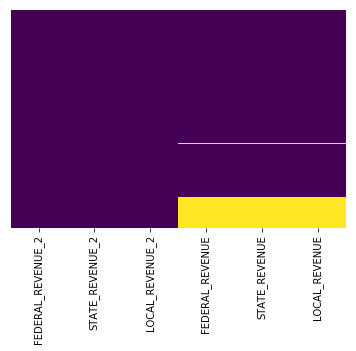

In [259]:
x=education[['FEDERAL_REVENUE_2','STATE_REVENUE_2','LOCAL_REVENUE_2','FEDERAL_REVENUE','STATE_REVENUE','LOCAL_REVENUE']]
sns.heatmap(x.isnull(),yticklabels=False,cbar=False,cmap='viridis')

**TOTAL_EXPENDITURE, INSTRUCTION_EXPENDITURE, SUPPORT_SERVICES_EXPENDITURE, CAPITAL_OUTLAY_EXPENDITURE, OTHER_EXPENDITURE columns**

I suspect there is a similar case with previous columns since TOTAL_EXPENDITURE is the result/sum of  INSTRUCTION_EXPENDITURE, SUPPORT_SERVICES_EXPENDITURE, CAPITAL_OUTLAY_EXPENDITURE and  OTHER_EXPENDITURE columns. Let's verify if that's true.

In [250]:
education['sum_TOTAL_EXPENDITURE'] = education[['INSTRUCTION_EXPENDITURE','SUPPORT_SERVICES_EXPENDITURE','CAPITAL_OUTLAY_EXPENDITURE','OTHER_EXPENDITURE']].sum(axis=1)
education[['sum_TOTAL_EXPENDITURE','TOTAL_EXPENDITURE','INSTRUCTION_EXPENDITURE','SUPPORT_SERVICES_EXPENDITURE','CAPITAL_OUTLAY_EXPENDITURE','OTHER_EXPENDITURE']].iloc[0:10]

,sum_TOTAL_EXPENDITURE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,OTHER_EXPENDITURE
0,2390792.0,2653798.0,1481703.0,735036.0,174053.0,NaN
1,886715.0,972488.0,498362.0,350902.0,37451.0,NaN
2,3052754.0,3401580.0,1435908.0,1007732.0,609114.0,NaN
3,1593023.0,1743022.0,964323.0,483488.0,145212.0,NaN
4,24924536.0,27138832.0,14358922.0,8520926.0,2044688.0,NaN
5,3043196.0,3264826.0,1642466.0,1035970.0,364760.0,NaN
6,3339183.0,3721338.0,2148041.0,1142600.0,48542.0,NaN
7,598232.0,638784.0,372722.0,194915.0,30595.0,NaN
8,693111.0,742893.0,329160.0,316679.0,47272.0,NaN
9,10244640.0,11305642.0,5166374.0,3410440.0,1667826.0,NaN


There is a difference between sum_TOTAL_EXPENDITURE (sum of 4 variables) and TOTAL_EXPENDITURE, so the aproach to clean those variables will be imputation. 

In [251]:
#Checking out OTHER_EXPENDITURE, this variable has a different percentage of null values
education[education['OTHER_EXPENDITURE'].isnull()]['YEAR'].value_counts()

1992    56
2017    51
2003     8
2006     8
1999     8
2000     8
2001     8
2002     8
2005     8
2004     8
2007     8
2013     7
2009     7
2011     7
2012     7
1998     7
2015     6
2010     6
1997     6
1996     6
2008     5
1995     5
1994     5
1993     5
2014     5
Name: YEAR, dtype: int64

In [252]:
education.OTHER_EXPENDITURE.isnull().value_counts()

False    1229
True      263
Name: OTHER_EXPENDITURE, dtype: int64

In [253]:
#Cleaning with imputation with mean()

#creating new variables
education[['TOTAL_EXPENDITURE_2','INSTRUCTION_EXPENDITURE_2','SUPPORT_SERVICES_EXPENDITURE_2','CAPITAL_OUTLAY_EXPENDITURE_2','OTHER_EXPENDITURE_2']]=education[['TOTAL_EXPENDITURE','INSTRUCTION_EXPENDITURE','SUPPORT_SERVICES_EXPENDITURE','CAPITAL_OUTLAY_EXPENDITURE','OTHER_EXPENDITURE']]

#Imputation with mean()
education['TOTAL_EXPENDITURE_2'].fillna(education['TOTAL_EXPENDITURE_2'].mean(),inplace=True)
education['INSTRUCTION_EXPENDITURE_2'].fillna(education['INSTRUCTION_EXPENDITURE_2'].mean(),inplace=True)
education['SUPPORT_SERVICES_EXPENDITURE_2'].fillna(education['SUPPORT_SERVICES_EXPENDITURE_2'].mean(),inplace=True)
education['CAPITAL_OUTLAY_EXPENDITURE_2'].fillna(education['CAPITAL_OUTLAY_EXPENDITURE_2'].mean(),inplace=True)
education['OTHER_EXPENDITURE_2'].fillna(education['OTHER_EXPENDITURE_2'].mean(),inplace=True)

#Verifying if there is null values
education.TOTAL_EXPENDITURE_2.isnull().sum()
education.INSTRUCTION_EXPENDITURE_2.isnull().sum()
education.SUPPORT_SERVICES_EXPENDITURE_2.isnull().sum()
education.CAPITAL_OUTLAY_EXPENDITURE_2.isnull().sum()
education.OTHER_EXPENDITURE_2.isnull().sum()


0

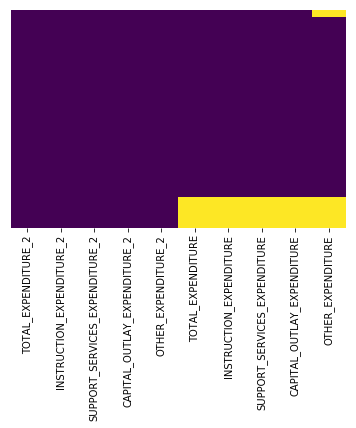

In [258]:
x= education[['TOTAL_EXPENDITURE_2','INSTRUCTION_EXPENDITURE_2','SUPPORT_SERVICES_EXPENDITURE_2','CAPITAL_OUTLAY_EXPENDITURE_2','OTHER_EXPENDITURE_2','TOTAL_EXPENDITURE','INSTRUCTION_EXPENDITURE','SUPPORT_SERVICES_EXPENDITURE','CAPITAL_OUTLAY_EXPENDITURE','OTHER_EXPENDITURE']]
sns.heatmap(x.isnull(),yticklabels=False,cbar=False,cmap='viridis')

_TOTAL-EXPENDITURE, INSTRUCTION-EXPENDITURE, SUPPORT-SERVICES-EXPENDITURE, CAPITAL-OUTLAY-EXPENDITURE, OTHER-EXPENDITURE columns are cleaning now_

In [255]:
education.head(5)

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,diff_totalrevenue,FEDERAL_REVENUE_2,STATE_REVENUE_2,LOCAL_REVENUE_2,sum_TOTAL_EXPENDITURE,TOTAL_EXPENDITURE_2,INSTRUCTION_EXPENDITURE_2,SUPPORT_SERVICES_EXPENDITURE_2,CAPITAL_OUTLAY_EXPENDITURE_2,OTHER_EXPENDITURE_2
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,0.0,304177.0,1659028.0,715680.0,2390792.0,2653798.0,1481703.0,735036.0,174053.0,429204.616762
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,0.0,106780.0,720711.0,222100.0,886715.0,972488.0,498362.0,350902.0,37451.0,429204.616762
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,0.0,297888.0,1369815.0,1590376.0,3052754.0,3401580.0,1435908.0,1007732.0,609114.0,429204.616762
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,0.0,178571.0,958785.0,574603.0,1593023.0,1743022.0,964323.0,483488.0,145212.0,429204.616762
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,0.0,2072470.0,16546514.0,7641041.0,24924536.0,27138832.0,14358922.0,8520926.0,2044688.0,429204.616762
